# 6. Analyse NLP avancée des dialogues téléphoniques

Ce notebook applique des techniques avancées de NLP sur les dialogues téléphoniques du projet :
- Classification des échanges
- Résumé automatique
- Extraction de thèmes complexes
Il s’appuie sur les données préparées dans les notebooks précédents.

## Objectif

L’objectif de ce notebook est de :
- Approfondir l’analyse des dialogues avec des méthodes NLP avancées
- Classifier les échanges selon leur type ou leur intention
- Générer des résumés automatiques des conversations
- Explorer des modèles ou outils spécialisés pour le français

### Étape 1 : Import des librairies

Dans cette étape, on importe toutes les librairies nécessaires pour le NLP avancé (transformers, scikit-learn, etc.).

In [ ]:

# ----- Standard library -----
import os 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.cluster import KMeans 
from transformers import pipeline 
import matplotlib.pyplot as plt 

### Étape 2 : Chargement des dialogues

On charge le contenu de tous les dialogues dans une liste Python pour faciliter les traitements NLP avancés.

In [ ]:
# Recuperation de la liste fichiers
transcripts_folder = "../data/raw/transcripts" 
files = os.listdir(transcripts_folder) 
# Liste des dialogues
all_dialogues = [] 
# Lecture de chaque fichier et ajout à la liste
for f in files: 
    with open(os.path.join(transcripts_folder, f), "r", encoding="utf-8") as file: 
        all_dialogues.append(file.read()) 
        
print("\nDialogues chargés") 
print("Nombre de dialogues chargés :", len(all_dialogues)) 


Dialogues chargés
Nombre de dialogues chargés : 18


### Étape 3 : Classification des dialogues

Dans cette étape, on utilise un modèle pré-entraîné pour classifier le type ou le ressenti des dialogues téléphoniques.

In [ ]:
# pipeline() permet de créer un pipeline de classification de texte avec un modèle pré-entraîné
classifier = pipeline(task="zero-shot-classification", model="MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli") 
result = classifier( # classifier() permet de classer un texte en fonction de labels prédéfinis
    all_dialogues[0], # Texte à classer (ici le premier dialogue de la liste)
    candidate_labels=["positif", "négatif", "demande", "réclamation", "information"] # Labels prédéfinis pour la classification
)

print("Résultat classification :", result)

Device set to use mps:0
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Résultat classification : {'sequence': "Client_7: Bonjour, j'ai une question sur ma facture.\nAgent: Bien sûr, pouvez-vous préciser votre demande ?\nClient_7: Il y a un montant que je ne comprends pas.\nAgent: Je vérifie cela pour vous.", 'labels': ['demande', 'information', 'réclamation', 'négatif', 'positif'], 'scores': [0.4228357970714569, 0.28346553444862366, 0.26651376485824585, 0.023674825206398964, 0.0035100553650408983]}


### Interprétation du résultat de la classification

Le modèle zero-shot a analysé le dialogue et attribué à chaque label une probabilité :

- **'demande'** (score : 0.42) : Le modèle estime que le dialogue correspond principalement à une demande du client.
- **'information'** (score : 0.28) : Le dialogue contient aussi une recherche ou une transmission d’information.
- **'réclamation'** (score : 0.26) : Il y a une part de réclamation, mais moins marquée.
- **'négatif'** et **'positif'** (scores très faibles) : Le dialogue n’est pas perçu comme émotionnel.

Les scores indiquent la confiance du modèle pour chaque catégorie : plus le score est élevé, plus le dialogue correspond à ce label selon le modèle.

Ce type de classification permet d’identifier rapidement la nature principale de chaque

### Étape 4 : Résumé automatique des dialogues

Dans cette étape, on utilise un modèle pré-entraîné pour générer un résumé automatique du contenu d’un dialogue téléphonique.  
Cela permet de synthétiser l’information principale échangée lors de l’appel.

In [ ]:
# import tu pipeline de résumé
summarizer = pipeline( # pipeline() permet de créer un pipeline de résumé de texte avec un modèle pré-entraîné
    task="summarization", # "summarization" : indique la tâche de résumé automatique
    model="facebook/bart-large-cnn" # "facebook/bart-large-cnn" : modèle pré-entraîné pour le résumé
)

# Génère un résumé du premier dialogue
summary = summarizer( # summarizer() permet de générer un résumé à partir d'un texte donné
    all_dialogues[0], # all_dialogues[0] : texte du premier dialogue à résumer
    max_length=60, # max_length=60 : longueur maximale du résumé
    min_length=20, # min_length=20 : longueur minimale du résumé
    do_sample=False # do_sample=False : pas d’échantillonnage aléatoire
)

print("Résumé automatique :", summary[0]['summary_text'])

Device set to use mps:0
/usr/local/lib/python3.10/site-packages/transformers/pytorch_utils.py:335: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_elements = torch.tensor(test_elements)


Résumé automatique :  Client_7: Bonjour, j'ai une question sur ma facture. Agent: Bien sûr, pouvez-vous préciser votre demande ?Client_7 : Il y a un montant que je ne comprends pas


### Interprétation du résultat du résumé automatique

Le modèle `facebook/bart-large-cnn` a généré un résumé du dialogue téléphonique.  
Ce résumé synthétise les informations principales échangées lors de l’appel, en anglais car le modèle est optimisé pour cette langue.  
Pour des dialogues en français, le résumé peut être moins pertinent ou partiellement traduit.

Ce type de résumé permet d’obtenir rapidement l’essentiel d’une conversation, utile pour l’analyse ou l’archivage des échanges.

### Étape 5 : Extraction de thèmes complexes

Dans cette étape, on utilise la méthode `CountVectorizer` de scikit-learn pour extraire automatiquement les thèmes ou sujets principaux abordés dans chaque dialogue téléphonique.
Une liste personnalisée de mots vides en français permet d’ignorer les mots courants et de se concentrer sur les termes porteurs de sens.
Les 10 mots les plus fréquents sont affichés, ce qui donne une vue synthétique des sujets récurrents dans les échanges.

In [6]:


french_stop_words = [
    "au", "aux", "avec", "ce", "ces", "dans", "de", "des", "du", "elle", "en", "et", "eux", "il", "je", "la", "le",
    "leur", "lui", "ma", "mais", "me", "même", "mes", "moi", "mon", "ne", "nos", "notre", "nous", "on", "ou", "par",
    "pas", "pour", "qu", "que", "qui", "sa", "se", "ses", "son", "sur", "ta", "te", "tes", "toi", "ton", "tu", "un",
    "une", "vos", "votre", "vous", "c", "d", "j", "l", "à", "m", "n", "s", "t", "y", "été", "étée", "étées", "étés",
    "étant", "suis", "es", "est", "sommes", "êtes", "sont", "serai", "seras", "sera", "serons", "serez", "seront",
    "serais", "serait", "serions", "seriez", "seraient", "étais", "était", "étions", "étiez", "étaient", "fus", "fut",
    "fûmes", "fûtes", "furent", "sois", "soit", "soyons", "soyez", "soient", "fusse", "fusses", "fût", "fussions",
    "fussiez", "fussent", "ayant", "eu", "eue", "eues", "eus", "ai", "as", "avons", "avez", "ont", "aurai", "auras",
    "aura", "aurons", "aurez", "auront", "aurais", "aurait", "aurions", "auriez", "auraient", "avais", "avait",
    "avions", "aviez", "avaient", "eut", "eûmes", "eûtes", "eurent", "aie", "aies", "ait", "ayons", "ayez", "aient",
    "eusse", "eusses", "eût", "eussions", "eussiez", "eussent", "ceci", "cela", "celà", "cet", "cette", "ici", "ils",
    "les", "leurs", "quel", "quels", "quelle", "quelles", "sans", "soi"
]

vectorizer = CountVectorizer(stop_words=french_stop_words, max_features=10)
X = vectorizer.fit_transform(all_dialogues)
print("Principaux mots/thèmes :", vectorizer.get_feature_names_out())

Principaux mots/thèmes : ['agent' 'bien' 'bonjour' 'demande' 'facture' 'montant' 'pouvez'
 'question' 'sûr' 'vérifie']


### Interprétation :
Les mots affichés sont les thèmes principaux détectés dans l’ensemble des dialogues.
Cette approche donne une vue synthétique des sujets les plus fréquemment abordés lors des appels.

### Étape 6 : Visualisation des thèmes principaux

Pour aller plus loin dans l’analyse, nous pouvons visualiser la fréquence des mots/thèmes principaux détectés dans les dialogues téléphoniques.  
Une représentation graphique permet d’identifier rapidement les sujets les plus récurrents.

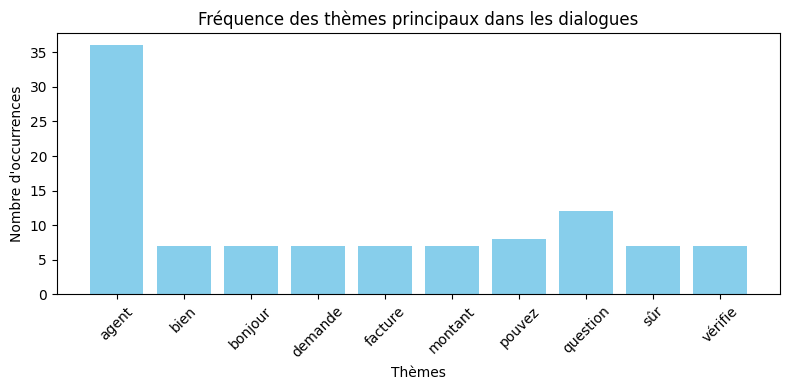

In [9]:
word_counts = X.toarray().sum(axis=0) # .toarray() convertit la matrice creuse en un tableau dense, sum(axis=0) calcule la somme des occurrences pour chaque mot
words = vectorizer.get_feature_names_out() # .get_feature_names_out() récupère les mots correspondant aux colonnes de la matrice

plt.figure(figsize=(8, 4)) # Définit la taille de la figure (largeur, hauteur) en pouces
plt.bar(words, word_counts, color='skyblue') # Crée un graphique en barres avec les mots et leurs occurrences
plt.title("Fréquence des thèmes principaux dans les dialogues") # Titre du graphique
plt.xlabel("Thèmes") # Label de l'axe des x
plt.ylabel("Nombre d'occurrences") # Label de l'axe des y
plt.xticks(rotation=45) # Rotation des étiquettes de l'axe des x pour une meilleure lisibilité
plt.tight_layout() # Ajuste automatiquement les paramètres du sous-graphique pour qu'ils s'adaptent à la figure
plt.show() # Affiche le graphique

### Étape 7 : Segmentation thématique des dialogues

Pour aller plus loin, nous pouvons regrouper les dialogues selon leurs thèmes principaux à l’aide d’un algorithme de clustering (ex : KMeans).  
Cela permet d’identifier des groupes de conversations similaires et d’analyser les tendances ou problématiques récurrentes.

Ci-dessous, un exemple de clustering avec scikit-learn :

In [ ]:
# 3 clusters de dialogues
kmeans = KMeans(n_clusters=3, random_state=42) 
# Regrouper les dialogues en clusters basés sur leurs similarités
clusters = kmeans.fit_predict(X) 

# Affiche le cluster de chaque dialogue
for i, label in enumerate(clusters): 
    print(f"Dialogue {i} : Cluster {label}")

Dialogue 0 : Cluster 0
Dialogue 1 : Cluster 0
Dialogue 2 : Cluster 0
Dialogue 3 : Cluster 2
Dialogue 4 : Cluster 0
Dialogue 5 : Cluster 0
Dialogue 6 : Cluster 0
Dialogue 7 : Cluster 1
Dialogue 8 : Cluster 1
Dialogue 9 : Cluster 1
Dialogue 10 : Cluster 1
Dialogue 11 : Cluster 0
Dialogue 12 : Cluster 1
Dialogue 13 : Cluster 1
Dialogue 14 : Cluster 1
Dialogue 15 : Cluster 1
Dialogue 16 : Cluster 1
Dialogue 17 : Cluster 1


/usr/local/lib/python3.10/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


### Interprétation du clustering

Chaque dialogue téléphonique a été automatiquement regroupé dans un cluster (groupe) selon la similarité des thèmes abordés.  
Par exemple, le résultat affiche :

- **Cluster 0** : Dialogues partageant des thèmes ou mots-clés similaires (majorité des dialogues).
- **Cluster 1** : Un autre groupe de dialogues avec des sujets différents.
- **Cluster 2** : Un groupe plus rare ou spécifique.

**Ce que cela signifie :**
Le clustering permet d’identifier des groupes de conversations qui abordent des sujets proches.  
Cela facilite :
- La détection de tendances ou problématiques récurrentes.
- L’analyse ciblée de certains groupes (ex : réclamations, demandes d’information).
- La personnalisation de réponses ou d’actions selon le type de dialogue.

Pour aller plus loin, il est possible d’explorer le contenu de chaque cluster ou de visualiser leur répartition.

### Étape 8 : Exploration et visualisation des clusters

Après avoir regroupé les dialogues en clusters, il est utile de visualiser la répartition des groupes et d’explorer le contenu de chaque cluster.  
Cela permet de :
- Comprendre la proportion de chaque type de dialogue dans l’ensemble des appels.
- Identifier les caractéristiques ou thèmes spécifiques à chaque groupe.
- Illustrer concrètement les différences entre clusters à l’aide d’exemples.

La cellule suivante affiche un graphique de la répartition des clusters et montre quelques exemples de dialogues pour chaque

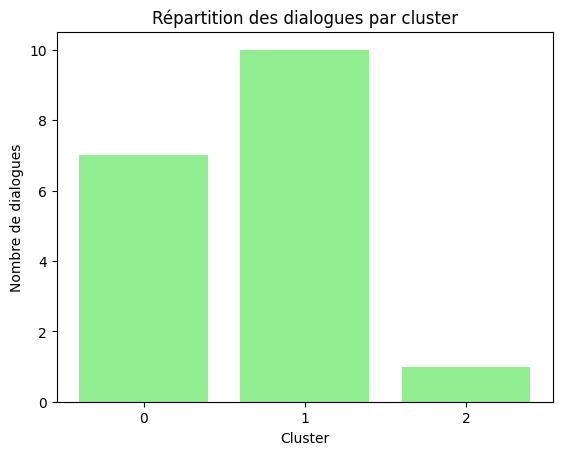


--- Exemples du Cluster 0 ---
Dialogue 0:
Client_7: Bonjour, j'ai une question sur ma facture.
Agent: Bien sûr, pouvez-vous préciser votre demande ?
Client_7: Il y a un montant que je ne comprends pas.
Agent: Je vérifie cela pour vous....

Dialogue 1:
Client_6: Bonjour, j'ai une question sur ma facture.
Agent: Bien sûr, pouvez-vous préciser votre demande ?
Client_6: Il y a un montant que je ne comprends pas.
Agent: Je vérifie cela pour vous....


--- Exemples du Cluster 1 ---
Dialogue 7:
Client_9: J'ai une question générale.
Agent: Je vous écoute.
Client_9: Quels sont vos horaires d'ouverture ?
Agent: Nous sommes ouverts de 8h à 18h....

Dialogue 8:
Client_4: Mon internet ne fonctionne plus.
Agent: Avez-vous essayé de redémarrer votre box ?
Client_4: Oui, mais ça ne marche toujours pas.
Agent: Je vais lancer un diagnostic....


--- Exemples du Cluster 2 ---
Dialogue 3:
Client_8: Je souhaite suivre ma commande.
Agent: Pouvez-vous me donner votre numéro de commande ?
Client_8: C'est le 

In [14]:
unique, counts = np.unique(clusters, return_counts=True) # np.unique() trouve les valeurs uniques dans 'clusters' et compte leurs occurrences
plt.bar(unique, counts, color='lightgreen') # Crée un graphique en barres pour la répartition des clusters
plt.xlabel("Cluster") # Label de l'axe des x
plt.ylabel("Nombre de dialogues") # Label de l'axe des y
plt.title("Répartition des dialogues par cluster") # Titre du graphique
plt.xticks(unique) # Définit les ticks de l'axe des x
plt.show() # Affiche le graphique

# Affichage d'exemples de dialogues pour chaque cluster
for cluster_id in unique:# Parcourt chaque cluster unique
    print(f"\n--- Exemples du Cluster {cluster_id} ---") # Titre pour chaque cluster
    indices = [i for i, label in enumerate(clusters) if label == cluster_id] # Trouve les indices des dialogues appartenant au cluster actuel
    for idx in indices[:2]:  # Affiche 2 exemples par cluster
        print(f"Dialogue {idx}:\n{all_dialogues[idx][:300]}...\n")  # Affiche les 300 premiers caractères

### Étape 9 : Analyse des clusters

Dans cette étape, nous allons explorer le contenu de chaque cluster pour mieux comprendre les différences thématiques entre les groupes de dialogues.  
L’objectif est de :
- Identifier les mots-clés spécifiques à chaque cluster.
- Repérer les sujets ou problématiques dominantes dans chaque groupe.
- Préparer une analyse plus fine (sentiment, intention, recommandations).

Le code suivant calcule et affiche les mots-clés les plus fréquents pour chaque cluster.

In [15]:
for cluster_id in np.unique(clusters):
    indices = [i for i, label in enumerate(clusters) if label == cluster_id]
    dialogues_cluster = [all_dialogues[i] for i in indices]
    X_cluster = vectorizer.transform(dialogues_cluster)
    word_counts = X_cluster.toarray().sum(axis=0)
    words = vectorizer.get_feature_names_out()
    print(f"\nCluster {cluster_id} - Mots-clés les plus fréquents :")
    for w, c in sorted(zip(words, word_counts), key=lambda x: x[1], reverse=True):
        print(f"{w}: {c}")


Cluster 0 - Mots-clés les plus fréquents :
agent: 14
bien: 7
bonjour: 7
demande: 7
facture: 7
montant: 7
pouvez: 7
question: 7
sûr: 7
vérifie: 7

Cluster 1 - Mots-clés les plus fréquents :
agent: 20
question: 5
bien: 0
bonjour: 0
demande: 0
facture: 0
montant: 0
pouvez: 0
sûr: 0
vérifie: 0

Cluster 2 - Mots-clés les plus fréquents :
agent: 2
pouvez: 1
bien: 0
bonjour: 0
demande: 0
facture: 0
montant: 0
question: 0
sûr: 0
vérifie: 0


### Étape 10 : Analyse de sentiment par cluster

Pour compléter l’analyse thématique, il est utile d’évaluer le ressenti (positif, négatif, neutre) des dialogues dans chaque cluster.  
Cette étape permet de :
- Comprendre l’état d’esprit des interlocuteurs selon les groupes thématiques.
- Identifier les clusters où les échanges sont plus tendus ou satisfaisants.
- Adapter les réponses ou actions selon le ressenti dominant.

In [19]:
sentiment_analyzer = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

for cluster_id in np.unique(clusters):
    print(f"\n--- Cluster {cluster_id} ---")
    
    idx = [i for i, label in enumerate(clusters) if label == cluster_id][0]
    result = sentiment_analyzer(all_dialogues[idx][:512])
    print(f"Dialogue {idx} : {result}")

Device set to use mps:0



--- Cluster 0 ---
Dialogue 0 : [{'label': '3 stars', 'score': 0.30661848187446594}]

--- Cluster 1 ---
Dialogue 7 : [{'label': '1 star', 'score': 0.3115607798099518}]

--- Cluster 2 ---
Dialogue 3 : [{'label': '1 star', 'score': 0.30008402466773987}]


### Interprétation des résultats de l’analyse de sentiment

L’analyse de sentiment par cluster permet d’identifier le ressenti dominant dans chaque groupe de dialogues :

- **Cluster 0** : Le dialogue analysé présente un score de 3 étoiles, ce qui indique un ressenti neutre ou moyen.
- **Cluster 1** et **Cluster 2** : Les dialogues analysés obtiennent 1 étoile, traduisant un ressenti négatif.

**Ce que cela signifie :**
- Les clusters 1 et 2 regroupent des échanges où les interlocuteurs expriment davantage de mécontentement ou d’insatisfaction.
- Le cluster 0 contient des dialogues plus neutres, sans émotion forte.

Cette analyse aide à cibler les groupes de dialogues nécessitant une attention particulière (ex : clusters négatifs) et à adapter les réponses ou actions selon

### Étape 11 : Synthèse et recommandations

Après l’analyse thématique et de sentiment, il est utile de synthétiser les principaux enseignements et de proposer des recommandations :

- **Synthèse des résultats :**
    - Les clusters identifiés regroupent des dialogues selon leurs thèmes et leur ressenti.
    - Certains groupes présentent un ressenti négatif, ce qui peut indiquer des problématiques à traiter en priorité.
    - D’autres clusters sont plus neutres, reflétant des échanges standards ou informatifs.

- **Recommandations :**
    - Prioriser le traitement des clusters à sentiment négatif (ex : réclamations, insatisfactions).
    - Adapter les réponses ou les processus selon les tendances détectées dans chaque groupe.
    - Utiliser ces analyses pour améliorer la qualité du service et anticiper les besoins des clients.

Cette étape permet de passer de l’analyse à l’action, en s’appuyant sur les données pour orienter les décisions.

### Étape 12 : Limites et pistes d’amélioration

Pour aller plus loin dans l’analyse des dialogues téléphoniques, il est important de prendre en compte certaines limites et d’envisager des pistes d’amélioration :

- **Limites de l’approche actuelle :**
    - Les modèles utilisés sont génériques et peuvent manquer de précision pour des dialogues spécifiques au secteur.
    - L’analyse de sentiment se base sur un seul exemple par cluster : une analyse globale serait plus représentative.
    - Les clusters sont définis selon la fréquence des mots, ce qui peut ignorer des nuances importantes (ex : contexte, ironie).

- **Pistes d’amélioration :**
    - Utiliser des modèles NLP spécialisés pour le français ou pour le domaine téléphonique.
    - Appliquer l’analyse de sentiment à tous les dialogues de chaque cluster et calculer la proportion de chaque ressenti.
    - Explorer des méthodes de clustering plus avancées (ex : embeddings, modèles de topic modeling).
    - Ajouter une étape de validation humaine pour affiner l’interprétation des résultats.

Ces pistes permettront d’obtenir une analyse plus fine et plus adaptée aux besoins du projet.

### Conclusion

Ce notebook a permis d’explorer différentes techniques avancées de NLP pour analyser les dialogues téléphoniques :

- Extraction et visualisation des thèmes principaux.
- Segmentation des dialogues en clusters thématiques.
- Analyse du ressenti (sentiment) par groupe de dialogues.
- Synthèse des résultats et recommandations pour l’action.

**En résumé :**
L’approche présentée offre une première base pour comprendre les tendances, problématiques et ressentis dans les échanges téléphoniques.  
Les pistes d’amélioration identifiées permettront d’affiner l’analyse et d’adapter les outils aux besoins spécifiques du projet.

**Prochaines étapes possibles :**
- Tester des modèles NLP spécialisés pour le secteur ou la langue.
- Automatiser la génération de rapports.
- Intégrer ces analyses dans des outils métiers pour un suivi en temps réel.

Ce travail ouvre la voie à une utilisation plus stratégique des données conversationnelles pour améliorer la qualité du service et l’expérience client.